* [#1478](https://github.com/salgo60/DIGG-skuggbacklog/issues/1478)
* Denna Notebook [1478 DIGG forum.ipynb](https://github.com/salgo60/DIGG-skuggbacklog/blob/master/Notebook/1478%20DIGG%20forum.ipynb)

Hämtar ämnen

In [1]:
import time

from datetime import datetime

now = datetime.now()
timestamp = now.timestamp()

start_time = time.time()
print("Start:", datetime.now().strftime("%Y-%m-%d %H:%M:%S"))

Start: 2025-12-12 11:41:56


In [2]:
import os
import json
import time
import requests

BASE_URL = "https://community.dataportal.se/api/topic"
OUTDIR = "hamtat"

START_TID = 1        # justera om du vill
END_TID = 3000       # gissa högt, scriptet hoppar över saknade
START_TID = 1074        
END_TID = 1079       

SLEEP = 0.3          # snäll mot servern

headers = {
    "User-Agent": "Forum-archiver/0.1 (analysis, public data)"
}

os.makedirs(OUTDIR, exist_ok=True)

def hamta_topic(tid):
    url = f"{BASE_URL}/{tid}"
    r = requests.get(url, headers=headers, timeout=20)
    if r.status_code == 200:
        return r.json()
    return None

def spara_topic(data):
    tid = data.get("tid")
    path = os.path.join(OUTDIR, f"topic_{tid}.json")
    with open(path, "w", encoding="utf-8") as f:
        json.dump(data, f, ensure_ascii=False, indent=2)
    print(f"✔ sparade topic {tid}")

def main():
    for tid in range(START_TID, END_TID + 1):
        try:
            data = hamta_topic(tid)
            if data and "posts" in data:
                spara_topic(data)
            else:
                print(f"– hoppade över {tid}")
        except Exception as e:
            print(f"⚠️ fel på {tid}: {e}")

        time.sleep(SLEEP)

if __name__ == "__main__":
    main()


✔ sparade topic 1074
✔ sparade topic 1075
✔ sparade topic 1076
✔ sparade topic 1077
✔ sparade topic 1078
– hoppade över 1079


## Analyser

In [3]:
import json
import glob
from pathlib import Path

import pandas as pd

# Mapp där du sparat alla JSON-filer, t.ex. "hamtat"
DATA_DIR = Path("hamtat")

rows = []

for path in DATA_DIR.glob("*.json"):
    with open(path, "r", encoding="utf-8") as f:
        topic = json.load(f)

    tid = topic.get("tid")
    title = topic.get("titleRaw") or topic.get("title")
    cid = topic.get("cid")
    slug = topic.get("slug")
    topic_timestamp = topic.get("timestampISO")

    for p in topic.get("posts", []):
        rows.append({
            "tid": tid,
            "cid": cid,
            "slug": slug,
            "topic_title": title,
            "topic_timestamp": topic_timestamp,
            "pid": p.get("pid"),
            "post_index": p.get("index"),
            "post_timestamp": p.get("timestampISO"),
            "uid": p.get("uid"),
            "username": p.get("username"),
            "content_html": p.get("content"),
            "content_len": len(p.get("content") or ""),
        })

df = pd.DataFrame(rows)

print("Antal topics:", df["tid"].nunique())
print("Antal poster:", len(df))
print("\nTopp 10 användare (antal poster):")
print(df.groupby("username")["pid"].count().sort_values(ascending=False).head(10))

print("\nTopp 10 topics (antal visningar):")
# hämta viewcount per topic (från första raden per tid)
topic_views = (
    df.drop_duplicates("tid")[["tid", "topic_title"]]
    .set_index("tid")
)
# läs in viewcount direkt från filerna
view_rows = []
for path in DATA_DIR.glob("*.json"):
    with open(path, "r", encoding="utf-8") as f:
        topic = json.load(f)
    view_rows.append({
        "tid": topic.get("tid"),
        "viewcount": topic.get("viewcount", 0)
    })
views_df = pd.DataFrame(view_rows).set_index("tid")

top_topics = (views_df.join(topic_views)
              .sort_values("viewcount", ascending=False)
              .head(10))
print(top_topics)


Antal topics: 833
Antal poster: 4076

Topp 10 användare (antal poster):
Series([], Name: pid, dtype: int64)

Topp 10 topics (antal visningar):
     viewcount                                        topic_title
tid                                                              
755      52341  Medskapa specifikationen för datadelning om ma...
430      50050                             Svenska vandringsleder
421      42009                                         Badplatser
87       27665  Hjälp folk att bada i sommar med Öppna Data! (...
543      19705                                        Fastigheter
708      15081  Vägledning för att publicera data om grillplatser
452      14529                     Samarbete kring Roda (e-arkiv)
202      13935  Önskemål: Ny rekommendation från DIGG om API:e...
160      12572                                    energy data api
576      12345  Hur du får tillgång till öppna data om laddsta...


In [4]:
df.head()

,tid,cid,slug,topic_title,topic_timestamp,pid,post_index,post_timestamp,uid,username,content_html,content_len
0,282,23,282/hjälp-nosad-och-dataportalens-communityfor...,Hjälp NOSAD och dataportalens communityforum a...,2022-01-11T17:30:39.030Z,1213,0,2022-01-11T17:30:39.030Z,62,None,"<p dir=""auto"">11 januari hade NOSAD (Network o...",5170
1,1059,23,1059/dataportal-se-har-stöd-för-sparql-queries...,"Dataportal.se har stöd för Sparql-queries, vis...",2025-10-06T09:12:42.687Z,5304,0,2025-10-06T09:12:42.687Z,127,None,"<p dir=""auto"">Hej tänkte bara meddela att en f...",4756
2,1059,23,1059/dataportal-se-har-stöd-för-sparql-queries...,"Dataportal.se har stöd för Sparql-queries, vis...",2025-10-06T09:12:42.687Z,5305,1,2025-10-06T10:06:41.301Z,1802,None,"<p dir=""auto"">Trevligt man kan undra varför de...",557
3,1059,23,1059/dataportal-se-har-stöd-för-sparql-queries...,"Dataportal.se har stöd för Sparql-queries, vis...",2025-10-06T09:12:42.687Z,5307,2,2025-10-06T12:31:26.643Z,127,None,"<p dir=""auto""><a class=""plugin-mentions-user p...",2021
4,1059,23,1059/dataportal-se-har-stöd-för-sparql-queries...,"Dataportal.se har stöd för Sparql-queries, vis...",2025-10-06T09:12:42.687Z,5309,3,2025-10-06T13:16:28.870Z,1802,None,"<p dir=""auto"">SPARQL det är bara att vibe prog...",1899


### Användare 

In [5]:
import requests
from bs4 import BeautifulSoup

def hamta_username(userslug):
    url = f"https://community.dataportal.se/user/{userslug}"
    r = requests.get(url, headers={"User-Agent": "ForumAnalysis/1.0"})
    r.raise_for_status()

    soup = BeautifulSoup(r.text, "html.parser")

    # NodeBB: username brukar ligga i h1 eller data-attribut
    h1 = soup.find("h1")
    if h1:
        return h1.text.strip()

    return None


In [6]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import time

BASE_URL = "https://community.dataportal.se/users"
HEADERS = {"User-Agent": "ForumAnalysis/1.0"}

rows = []
seen_uids = set()

page = 1

while True:
    params = {
        "section": "sort-posts",
        "page": page
    }

    print(f"Hämtar users, sida {page} …")
    r = requests.get(BASE_URL, headers=HEADERS, params=params, timeout=20)
    r.raise_for_status()

    soup = BeautifulSoup(r.text, "html.parser")

    found_on_page = 0

    for tag in soup.find_all(attrs={"data-uid": True}):
        uid = tag.get("data-uid")
        username = tag.get("alt") or tag.get("title")

        if uid and username:
            uid = int(uid)
            if uid not in seen_uids:
                rows.append({
                    "uid": uid,
                    "username": username.strip()
                })
                seen_uids.add(uid)
                found_on_page += 1

    if found_on_page == 0:
        print("Inga nya användare hittade – stoppar.")
        break

    page += 1
    time.sleep(0.5)   # var snäll mot servern

users_df = pd.DataFrame(rows).sort_values("uid")

print(f"\nTotalt antal användare: {len(users_df)}")
print(users_df.head())

users_df.to_csv("users_uid_username.csv", index=False)
print("Sparade users_uid_username.csv")


Hämtar users, sida 1 …
Hämtar users, sida 2 …
Hämtar users, sida 3 …
Hämtar users, sida 4 …
Hämtar users, sida 5 …
Hämtar users, sida 6 …
Hämtar users, sida 7 …
Hämtar users, sida 8 …
Hämtar users, sida 9 …
Hämtar users, sida 10 …
Hämtar users, sida 11 …
Hämtar users, sida 12 …
Hämtar users, sida 13 …
Hämtar users, sida 14 …
Hämtar users, sida 15 …
Hämtar users, sida 16 …
Hämtar users, sida 17 …
Inga nya användare hittade – stoppar.

Totalt antal användare: 787
     uid        username
86     1  erik.viklander
220    3         AnnikaD
8      7       Kristine_
221    8            Adam
5      9  Björn Hagström
Sparade users_uid_username.csv


In [7]:
df = df.merge(users_df, on="uid", how="left")

In [8]:
df

,tid,cid,slug,topic_title,topic_timestamp,pid,post_index,post_timestamp,uid,username_x,content_html,content_len,username_y
0,282,23,282/hjälp-nosad-och-dataportalens-communityfor...,Hjälp NOSAD och dataportalens communityforum a...,2022-01-11T17:30:39.030Z,1213,0,2022-01-11T17:30:39.030Z,62,None,"<p dir=""auto"">11 januari hade NOSAD (Network o...",5170,Maria_Dalhage
1,1059,23,1059/dataportal-se-har-stöd-för-sparql-queries...,"Dataportal.se har stöd för Sparql-queries, vis...",2025-10-06T09:12:42.687Z,5304,0,2025-10-06T09:12:42.687Z,127,None,"<p dir=""auto"">Hej tänkte bara meddela att en f...",4756,tomasmonsen
2,1059,23,1059/dataportal-se-har-stöd-för-sparql-queries...,"Dataportal.se har stöd för Sparql-queries, vis...",2025-10-06T09:12:42.687Z,5305,1,2025-10-06T10:06:41.301Z,1802,None,"<p dir=""auto"">Trevligt man kan undra varför de...",557,Magnus Sälgö
3,1059,23,1059/dataportal-se-har-stöd-för-sparql-queries...,"Dataportal.se har stöd för Sparql-queries, vis...",2025-10-06T09:12:42.687Z,5307,2,2025-10-06T12:31:26.643Z,127,None,"<p dir=""auto""><a class=""plugin-mentions-user p...",2021,tomasmonsen
4,1059,23,1059/dataportal-se-har-stöd-för-sparql-queries...,"Dataportal.se har stöd för Sparql-queries, vis...",2025-10-06T09:12:42.687Z,5309,3,2025-10-06T13:16:28.870Z,1802,None,"<p dir=""auto"">SPARQL det är bara att vibe prog...",1899,Magnus Sälgö
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4071,429,4,429/kommunicera-driftsfönster-avvecklingar-och...,"Kommunicera driftsfönster, avvecklingar och ny...",2022-09-04T10:45:00.210Z,2134,5,2022-09-05T08:23:59.932Z,216,None,"<p dir=""auto""><a class=""plugin-mentions-user p...",434,Nina_Berlin
4072,429,4,429/kommunicera-driftsfönster-avvecklingar-och...,"Kommunicera driftsfönster, avvecklingar och ny...",2022-09-04T10:45:00.210Z,2143,6,2022-09-05T12:01:23.504Z,128,None,"<p dir=""auto""><a class=""plugin-mentions-user p...",553,Stefan Wallin
4073,429,4,429/kommunicera-driftsfönster-avvecklingar-och...,"Kommunicera driftsfönster, avvecklingar och ny...",2022-09-04T10:45:00.210Z,2145,7,2022-09-05T13:16:56.460Z,78,None,"<p dir=""auto""><a class=""plugin-mentions-user p...",334,jonass
4074,429,4,429/kommunicera-driftsfönster-avvecklingar-och...,"Kommunicera driftsfönster, avvecklingar och ny...",2022-09-04T10:45:00.210Z,2220,8,2022-09-08T17:20:49.202Z,172,None,"<p dir=""auto""><a class=""plugin-mentions-user p...",546,Peter_Bengtsson


In [9]:
df["post_date"] = pd.to_datetime(df["post_timestamp"]).dt.date
print(df.groupby("post_date")["pid"].count().tail(4))
print(df.groupby("post_date")["pid"].count().head(4))


post_date
2025-12-06    1
2025-12-07    2
2025-12-11    1
2025-12-12    6
Name: pid, dtype: int64
post_date
2021-01-28    1
2021-01-29    2
2021-01-30    2
2021-02-01    3
Name: pid, dtype: int64


In [10]:
replies_per_topic = df.groupby("tid")["pid"].count() - 1  # minus första inlägget
print(replies_per_topic.sort_values().head(20))

tid
1078    0
847     0
848     0
363     0
851     0
852     0
359     0
856     0
356     0
369     0
355     0
353     0
352     0
351     0
350     0
858     0
859     0
345     0
860     0
354     0
Name: pid, dtype: int64


In [11]:
df.columns

Index(['tid', 'cid', 'slug', 'topic_title', 'topic_timestamp', 'pid',
       'post_index', 'post_timestamp', 'uid', 'username_x', 'content_html',
       'content_len', 'username_y', 'post_date'],
      dtype='object')

In [12]:
# använd username_y från users-joinen
df["username"] = df["username_y"]

# städa bort dubletter
df = df.drop(columns=["username_x", "username_y"])

In [13]:
df["username_norm"] = (
    df["username"]
      .astype(str)
      .str.strip()
      .str.lower()
)
digg_users = ["digg_admin", "josefinlassi","mkfsk","digitalist-ops","mikkeschiren", 
             "fabian-von-tiedemann","fnordlander","tony","jenniferskoglund","maria_dalhage",
             "nina_berlin","kristine_","sven-erik"]  

digg_users_norm = {u.lower() for u in digg_users}

df_digg = df[df["username_norm"].isin(digg_users_norm)]

df_digg.groupby("username_norm")["pid"].count().sort_values(ascending=False)
df_digg = df[df["username_norm"].isin(digg_users)]
print(df_digg.groupby("username_norm")["pid"].count())


username_norm
digg_admin           46
jenniferskoglund     29
josefinlassi        133
kristine_           112
maria_dalhage       440
mikkeschiren         10
nina_berlin         176
sven-erik             7
Name: pid, dtype: int64


In [14]:
digg_users_norm = {u.lower() for u in digg_users}
df["is_digg"] = df["username_norm"].isin(digg_users_norm)


In [15]:
df.head()

,tid,cid,slug,topic_title,topic_timestamp,pid,post_index,post_timestamp,uid,content_html,content_len,post_date,username,username_norm,is_digg
0,282,23,282/hjälp-nosad-och-dataportalens-communityfor...,Hjälp NOSAD och dataportalens communityforum a...,2022-01-11T17:30:39.030Z,1213,0,2022-01-11T17:30:39.030Z,62,"<p dir=""auto"">11 januari hade NOSAD (Network o...",5170,2022-01-11,Maria_Dalhage,maria_dalhage,True
1,1059,23,1059/dataportal-se-har-stöd-för-sparql-queries...,"Dataportal.se har stöd för Sparql-queries, vis...",2025-10-06T09:12:42.687Z,5304,0,2025-10-06T09:12:42.687Z,127,"<p dir=""auto"">Hej tänkte bara meddela att en f...",4756,2025-10-06,tomasmonsen,tomasmonsen,False
2,1059,23,1059/dataportal-se-har-stöd-för-sparql-queries...,"Dataportal.se har stöd för Sparql-queries, vis...",2025-10-06T09:12:42.687Z,5305,1,2025-10-06T10:06:41.301Z,1802,"<p dir=""auto"">Trevligt man kan undra varför de...",557,2025-10-06,Magnus Sälgö,magnus sälgö,False
3,1059,23,1059/dataportal-se-har-stöd-för-sparql-queries...,"Dataportal.se har stöd för Sparql-queries, vis...",2025-10-06T09:12:42.687Z,5307,2,2025-10-06T12:31:26.643Z,127,"<p dir=""auto""><a class=""plugin-mentions-user p...",2021,2025-10-06,tomasmonsen,tomasmonsen,False
4,1059,23,1059/dataportal-se-har-stöd-för-sparql-queries...,"Dataportal.se har stöd för Sparql-queries, vis...",2025-10-06T09:12:42.687Z,5309,3,2025-10-06T13:16:28.870Z,1802,"<p dir=""auto"">SPARQL det är bara att vibe prog...",1899,2025-10-06,Magnus Sälgö,magnus sälgö,False


In [16]:
# Antal trådar med antal poster dvs. 280 har bara startpost
df.groupby("tid")["pid"].count().value_counts().head(10)


pid
1     282
2     121
3      86
4      70
20     55
5      48
6      34
8      25
7      24
9      16
Name: count, dtype: int64

In [17]:
replies_per_topic.sort_values(ascending=False).head(10)

tid
385     19
422     19
500     19
87      19
1020    19
576     19
265     19
873     19
498     19
312     19
Name: pid, dtype: int64

In [18]:
#Obsvarade  
unanswered = replies_per_topic[replies_per_topic == 0]

print("Antal obesvarade trådar:", len(unanswered))

df[df["tid"].isin(unanswered.index)][
    ["tid", "topic_title"]
].drop_duplicates().head(20)


Antal obesvarade trådar: 282


,tid,topic_title
0,282,Hjälp NOSAD och dataportalens communityforum a...
10,328,Hur kan vi förbättra möjligheten för er att ef...
31,847,"Videos från konferensen ""Hållbar digitaliserin..."
32,902,EDPB Website Auditing Tool
99,369,Standardiseringssatsning BEAst och Peppol
111,555,Sverige i Europas dataekosystem - 15 december ...
112,806,Söka geodata genom api.et
113,943,Om den här kategorin
114,294,Informationsmöte om revideringen av eIDAS-föro...
121,851,Lutece Translation Hackathon från den 16 oktober


In [19]:
replies_per_topic = df.groupby("tid")["pid"].count() - 1
replies_per_topic

tid
21       2
22       3
23       4
24       1
25       4
        ..
1074    10
1075     4
1076     0
1077     4
1078     0
Name: pid, Length: 833, dtype: int64

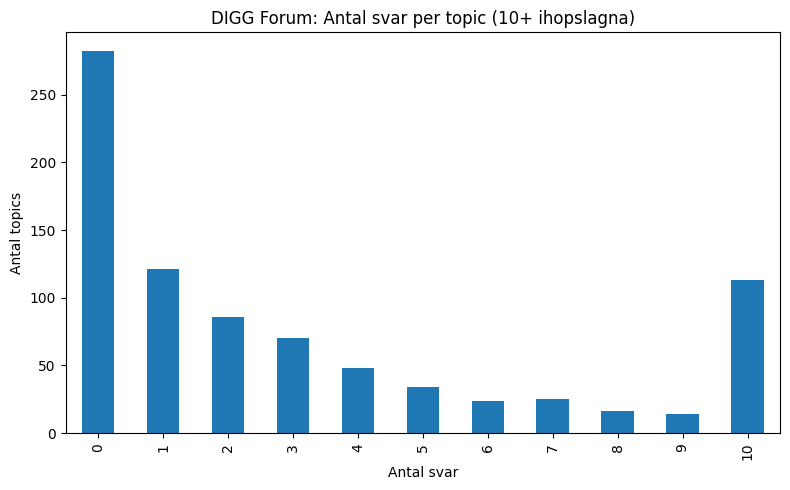

In [20]:
import matplotlib.pyplot as plt

replies = df.groupby("tid")["pid"].count() - 1

plt.figure(figsize=(8,5))
replies.clip(upper=10).value_counts().sort_index().plot(kind="bar")
plt.title("DIGG Forum: Antal svar per topic (10+ ihopslagna)")
plt.xlabel("Antal svar")
plt.ylabel("Antal topics")
plt.tight_layout()
plt.show()


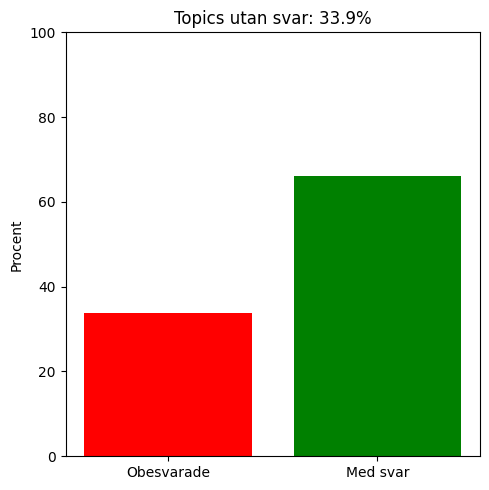

In [21]:
# Andel obesvarade topics (den här är brutal)   
share_unanswered = (replies == 0).mean() * 100

plt.figure(figsize=(5,5))
plt.bar(["Obesvarade", "Med svar"], 
        [share_unanswered, 100-share_unanswered],
        color=["red", "green"])
plt.ylabel("Procent")
plt.title(f"Topics utan svar: {share_unanswered:.1f}%")
plt.ylim(0,100)
plt.tight_layout()
plt.show()


/var/folders/fd/md6r13sj0wsbg_6_xl160d300000gn/T/ipykernel_22262/3619384270.py:2: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df["post_date"] = pd.to_datetime(df["post_timestamp"]).dt.to_period("M")


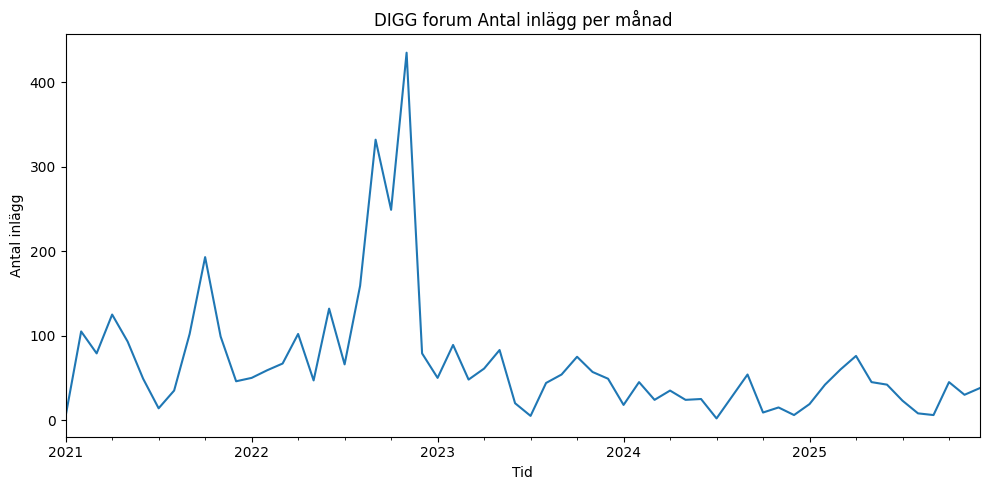

In [22]:
# Aktivitet över tid (dör forumet?) 
df["post_date"] = pd.to_datetime(df["post_timestamp"]).dt.to_period("M")

posts_per_month = df.groupby("post_date")["pid"].count()

plt.figure(figsize=(10,5))
posts_per_month.plot()
plt.title("DIGG forum Antal inlägg per månad")
plt.ylabel("Antal inlägg")
plt.xlabel("Tid")
plt.tight_layout()
plt.show()


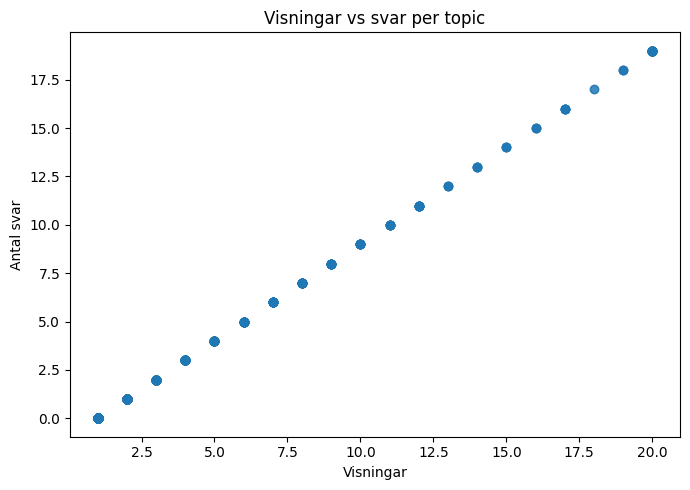

In [23]:
# Scatter: visningar vs svar (”engagemang”) 
topic_meta = (
    df.groupby("tid")
      .agg(
          replies=("pid", lambda x: len(x)-1),
          viewcount=("tid", "count")
      )
)

plt.figure(figsize=(7,5))
plt.scatter(topic_meta["viewcount"], topic_meta["replies"], alpha=0.6)
plt.xlabel("Visningar")
plt.ylabel("Antal svar")
plt.title("Visningar vs svar per topic")
plt.tight_layout()
plt.show()


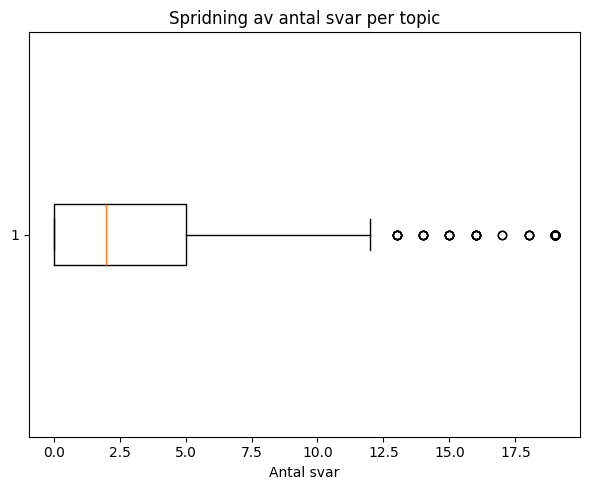

In [24]:
# (Valfri men stark) Boxplot replies 
plt.figure(figsize=(6,5))
plt.boxplot(replies, vert=False)
plt.title("Spridning av antal svar per topic")
plt.xlabel("Antal svar")
plt.tight_layout()
plt.show()


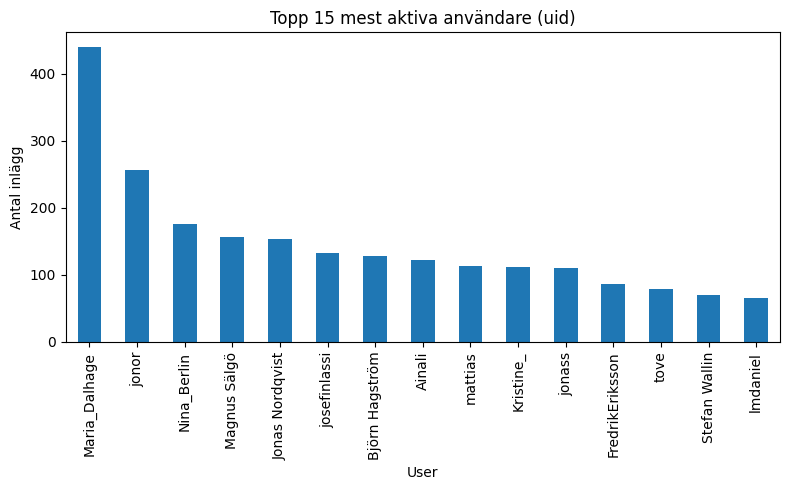

In [25]:
posts_per_user = df.groupby("username")["pid"].count().sort_values(ascending=False)

posts_per_user.head(15).plot(kind="bar", figsize=(8,5))
plt.title("Topp 15 mest aktiva användare (uid)")
plt.ylabel("Antal inlägg")
plt.xlabel("User")
plt.tight_layout()
plt.show()


In [26]:
df["username"].isna().mean()


0.2055937193326791

In [27]:
df.head()

,tid,cid,slug,topic_title,topic_timestamp,pid,post_index,post_timestamp,uid,content_html,content_len,post_date,username,username_norm,is_digg
0,282,23,282/hjälp-nosad-och-dataportalens-communityfor...,Hjälp NOSAD och dataportalens communityforum a...,2022-01-11T17:30:39.030Z,1213,0,2022-01-11T17:30:39.030Z,62,"<p dir=""auto"">11 januari hade NOSAD (Network o...",5170,2022-01,Maria_Dalhage,maria_dalhage,True
1,1059,23,1059/dataportal-se-har-stöd-för-sparql-queries...,"Dataportal.se har stöd för Sparql-queries, vis...",2025-10-06T09:12:42.687Z,5304,0,2025-10-06T09:12:42.687Z,127,"<p dir=""auto"">Hej tänkte bara meddela att en f...",4756,2025-10,tomasmonsen,tomasmonsen,False
2,1059,23,1059/dataportal-se-har-stöd-för-sparql-queries...,"Dataportal.se har stöd för Sparql-queries, vis...",2025-10-06T09:12:42.687Z,5305,1,2025-10-06T10:06:41.301Z,1802,"<p dir=""auto"">Trevligt man kan undra varför de...",557,2025-10,Magnus Sälgö,magnus sälgö,False
3,1059,23,1059/dataportal-se-har-stöd-för-sparql-queries...,"Dataportal.se har stöd för Sparql-queries, vis...",2025-10-06T09:12:42.687Z,5307,2,2025-10-06T12:31:26.643Z,127,"<p dir=""auto""><a class=""plugin-mentions-user p...",2021,2025-10,tomasmonsen,tomasmonsen,False
4,1059,23,1059/dataportal-se-har-stöd-för-sparql-queries...,"Dataportal.se har stöd för Sparql-queries, vis...",2025-10-06T09:12:42.687Z,5309,3,2025-10-06T13:16:28.870Z,1802,"<p dir=""auto"">SPARQL det är bara att vibe prog...",1899,2025-10,Magnus Sälgö,magnus sälgö,False


In [28]:
# Hur många topics saknar DIGG‑svar helt?
topic_has_digg = df.groupby("tid")["is_digg"].any()
(topic_has_digg == False).mean()


0.4525810324129652

In [29]:
# DIGG är inte närvarande antal DIGG inlägg
df_digg["pid"].count()

953

In [30]:
# Hur många diskussioner får aldrig DIGG‑svar?  
topic_has_digg = df.groupby("tid")["is_digg"].any()
(topic_has_digg == False).mean()


0.4525810324129652

In [31]:
# räkna bort Maria 
df_no_maria = df[
    df["username_norm"].isin(digg_users_norm)
    & (df["username_norm"] != "maria_dalhage")
]


In [32]:
# Hur mycket av DIGG‑närvaron försvinner med Maria 951 vs. 511

total_digg_posts = df[df["is_digg"]]["pid"].count()
digg_wo_maria_posts = df_no_maria["pid"].count()

total_digg_posts, digg_wo_maria_posts


(953, 513)

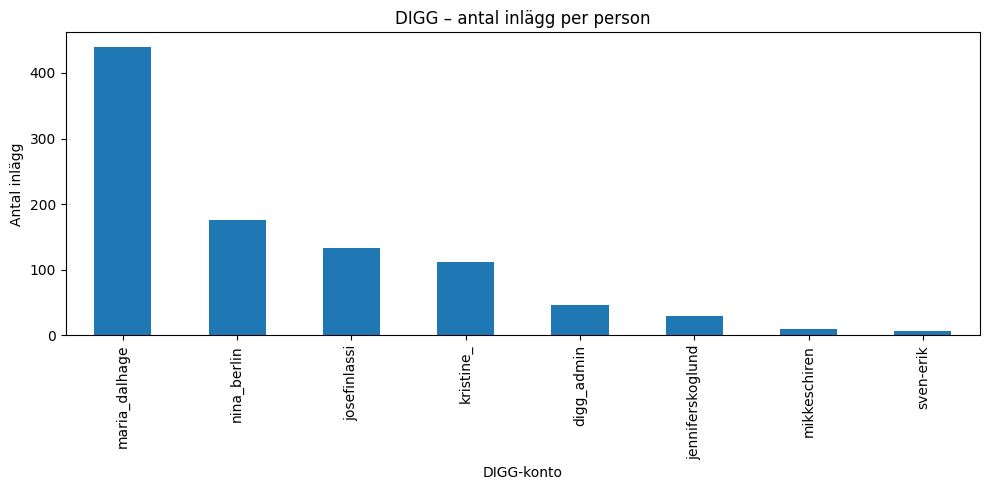

In [33]:
# DIGG – poster per person (totalt) 
import matplotlib.pyplot as plt

posts_per_person = (
    df_digg
    .groupby("username_norm")["pid"]
    .count()
    .sort_values(ascending=False)
)

plt.figure(figsize=(10,5))
posts_per_person.plot(kind="bar")
plt.title("DIGG – antal inlägg per person")
plt.ylabel("Antal inlägg")
plt.xlabel("DIGG‑konto")
plt.tight_layout()
plt.show()


In [34]:
df["post_date"].dtype

period[M]

In [35]:
[df.columns for c in df.columns if "time" in c.lower() or "date" in c.lower()]


[Index(['tid', 'cid', 'slug', 'topic_title', 'topic_timestamp', 'pid',
        'post_index', 'post_timestamp', 'uid', 'content_html', 'content_len',
        'post_date', 'username', 'username_norm', 'is_digg'],
       dtype='object'),
 Index(['tid', 'cid', 'slug', 'topic_title', 'topic_timestamp', 'pid',
        'post_index', 'post_timestamp', 'uid', 'content_html', 'content_len',
        'post_date', 'username', 'username_norm', 'is_digg'],
       dtype='object'),
 Index(['tid', 'cid', 'slug', 'topic_title', 'topic_timestamp', 'pid',
        'post_index', 'post_timestamp', 'uid', 'content_html', 'content_len',
        'post_date', 'username', 'username_norm', 'is_digg'],
       dtype='object')]

In [36]:
df["post_date"] = pd.to_datetime(
    df["post_timestamp"],
    errors="coerce",
    utc=True
)


In [37]:
df["post_month"] = df["post_date"].dt.strftime("%Y-%m")

In [38]:
df[["post_timestamp", "post_date", "post_month"]].head(5)

,post_timestamp,post_date,post_month
0,2022-01-11T17:30:39.030Z,2022-01-11 17:30:39.030000+00:00,2022-01
1,2025-10-06T09:12:42.687Z,2025-10-06 09:12:42.687000+00:00,2025-10
2,2025-10-06T10:06:41.301Z,2025-10-06 10:06:41.301000+00:00,2025-10
3,2025-10-06T12:31:26.643Z,2025-10-06 12:31:26.643000+00:00,2025-10
4,2025-10-06T13:16:28.870Z,2025-10-06 13:16:28.870000+00:00,2025-10


In [39]:
df.head()

,tid,cid,slug,topic_title,topic_timestamp,pid,post_index,post_timestamp,uid,content_html,content_len,post_date,username,username_norm,is_digg,post_month
0,282,23,282/hjälp-nosad-och-dataportalens-communityfor...,Hjälp NOSAD och dataportalens communityforum a...,2022-01-11T17:30:39.030Z,1213,0,2022-01-11T17:30:39.030Z,62,"<p dir=""auto"">11 januari hade NOSAD (Network o...",5170,2022-01-11 17:30:39.030000+00:00,Maria_Dalhage,maria_dalhage,True,2022-01
1,1059,23,1059/dataportal-se-har-stöd-för-sparql-queries...,"Dataportal.se har stöd för Sparql-queries, vis...",2025-10-06T09:12:42.687Z,5304,0,2025-10-06T09:12:42.687Z,127,"<p dir=""auto"">Hej tänkte bara meddela att en f...",4756,2025-10-06 09:12:42.687000+00:00,tomasmonsen,tomasmonsen,False,2025-10
2,1059,23,1059/dataportal-se-har-stöd-för-sparql-queries...,"Dataportal.se har stöd för Sparql-queries, vis...",2025-10-06T09:12:42.687Z,5305,1,2025-10-06T10:06:41.301Z,1802,"<p dir=""auto"">Trevligt man kan undra varför de...",557,2025-10-06 10:06:41.301000+00:00,Magnus Sälgö,magnus sälgö,False,2025-10
3,1059,23,1059/dataportal-se-har-stöd-för-sparql-queries...,"Dataportal.se har stöd för Sparql-queries, vis...",2025-10-06T09:12:42.687Z,5307,2,2025-10-06T12:31:26.643Z,127,"<p dir=""auto""><a class=""plugin-mentions-user p...",2021,2025-10-06 12:31:26.643000+00:00,tomasmonsen,tomasmonsen,False,2025-10
4,1059,23,1059/dataportal-se-har-stöd-för-sparql-queries...,"Dataportal.se har stöd för Sparql-queries, vis...",2025-10-06T09:12:42.687Z,5309,3,2025-10-06T13:16:28.870Z,1802,"<p dir=""auto"">SPARQL det är bara att vibe prog...",1899,2025-10-06 13:16:28.870000+00:00,Magnus Sälgö,magnus sälgö,False,2025-10


In [40]:
import pandas as pd

# säkerställ datetime
df["post_date"] = pd.to_datetime(df["post_date"], errors="coerce")

# skapa månad som STRING (inte Period!)
df["post_month"] = df["post_date"].dt.strftime("%Y-%m")


In [41]:
df

,tid,cid,slug,topic_title,topic_timestamp,pid,post_index,post_timestamp,uid,content_html,content_len,post_date,username,username_norm,is_digg,post_month
0,282,23,282/hjälp-nosad-och-dataportalens-communityfor...,Hjälp NOSAD och dataportalens communityforum a...,2022-01-11T17:30:39.030Z,1213,0,2022-01-11T17:30:39.030Z,62,"<p dir=""auto"">11 januari hade NOSAD (Network o...",5170,2022-01-11 17:30:39.030000+00:00,Maria_Dalhage,maria_dalhage,True,2022-01
1,1059,23,1059/dataportal-se-har-stöd-för-sparql-queries...,"Dataportal.se har stöd för Sparql-queries, vis...",2025-10-06T09:12:42.687Z,5304,0,2025-10-06T09:12:42.687Z,127,"<p dir=""auto"">Hej tänkte bara meddela att en f...",4756,2025-10-06 09:12:42.687000+00:00,tomasmonsen,tomasmonsen,False,2025-10
2,1059,23,1059/dataportal-se-har-stöd-för-sparql-queries...,"Dataportal.se har stöd för Sparql-queries, vis...",2025-10-06T09:12:42.687Z,5305,1,2025-10-06T10:06:41.301Z,1802,"<p dir=""auto"">Trevligt man kan undra varför de...",557,2025-10-06 10:06:41.301000+00:00,Magnus Sälgö,magnus sälgö,False,2025-10
3,1059,23,1059/dataportal-se-har-stöd-för-sparql-queries...,"Dataportal.se har stöd för Sparql-queries, vis...",2025-10-06T09:12:42.687Z,5307,2,2025-10-06T12:31:26.643Z,127,"<p dir=""auto""><a class=""plugin-mentions-user p...",2021,2025-10-06 12:31:26.643000+00:00,tomasmonsen,tomasmonsen,False,2025-10
4,1059,23,1059/dataportal-se-har-stöd-för-sparql-queries...,"Dataportal.se har stöd för Sparql-queries, vis...",2025-10-06T09:12:42.687Z,5309,3,2025-10-06T13:16:28.870Z,1802,"<p dir=""auto"">SPARQL det är bara att vibe prog...",1899,2025-10-06 13:16:28.870000+00:00,Magnus Sälgö,magnus sälgö,False,2025-10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4071,429,4,429/kommunicera-driftsfönster-avvecklingar-och...,"Kommunicera driftsfönster, avvecklingar och ny...",2022-09-04T10:45:00.210Z,2134,5,2022-09-05T08:23:59.932Z,216,"<p dir=""auto""><a class=""plugin-mentions-user p...",434,2022-09-05 08:23:59.932000+00:00,Nina_Berlin,nina_berlin,True,2022-09
4072,429,4,429/kommunicera-driftsfönster-avvecklingar-och...,"Kommunicera driftsfönster, avvecklingar och ny...",2022-09-04T10:45:00.210Z,2143,6,2022-09-05T12:01:23.504Z,128,"<p dir=""auto""><a class=""plugin-mentions-user p...",553,2022-09-05 12:01:23.504000+00:00,Stefan Wallin,stefan wallin,False,2022-09
4073,429,4,429/kommunicera-driftsfönster-avvecklingar-och...,"Kommunicera driftsfönster, avvecklingar och ny...",2022-09-04T10:45:00.210Z,2145,7,2022-09-05T13:16:56.460Z,78,"<p dir=""auto""><a class=""plugin-mentions-user p...",334,2022-09-05 13:16:56.460000+00:00,jonass,jonass,False,2022-09
4074,429,4,429/kommunicera-driftsfönster-avvecklingar-och...,"Kommunicera driftsfönster, avvecklingar och ny...",2022-09-04T10:45:00.210Z,2220,8,2022-09-08T17:20:49.202Z,172,"<p dir=""auto""><a class=""plugin-mentions-user p...",546,2022-09-08 17:20:49.202000+00:00,Peter_Bengtsson,peter_bengtsson,False,2022-09


In [42]:
# Export json 
df.to_json(
    "forum_posts_clean.json",
    orient="records",
    lines=True,
    force_ascii=False,
    date_format="iso"
)

In [43]:
df.to_json("forum_data.json", orient="records", force_ascii=False)


In [44]:
 # End timer and calculate duration
end_time = time.time()
elapsed_time = end_time - start_time# Bygg audit-lager för den här etappen

# Print current date and total time
print("Date:", datetime.now().strftime("%Y-%m-%d %H:%M:%S"))
minutes, seconds = divmod(elapsed_time, 60)
print("Total time elapsed: {:02.0f} minutes {:05.2f} seconds".format(minutes, seconds))


Date: 2025-12-12 11:42:12
Total time elapsed: 00 minutes 15.83 seconds
